In [31]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
#Get data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
combined = pd.concat([train, test], axis=0)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8418 entries, 0 to 4208
Columns: 378 entries, ID to y
dtypes: float64(1), int64(369), object(8)
memory usage: 24.3+ MB


In [51]:
#Preprocessing
train_c = train.copy()
test_c = test.copy()
train_c['label'] = train_c.y
train_c.drop(['ID', 'y'], inplace=True, axis=1)
test_c.drop('ID', inplace=True, axis=1)

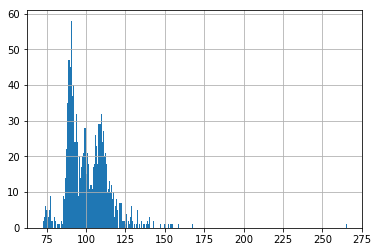

In [34]:
#Histogram of y; has four peaks
train_c.label.hist(bins=1000)
plt.show()

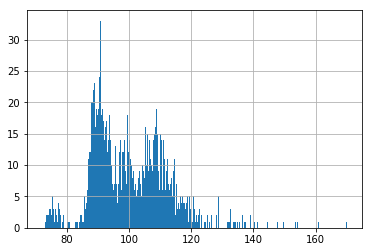

In [35]:
#Drop the y-outlier
train_c = train_c[train_c.label < 175]
train_c.label.hist(bins=1000)
plt.show()

In [52]:
#divide features into qualitative and quantitative
qual = []
quan = []
for col in train_c.columns[:-1]:
    if train_c[col].dtype == 'object':
        qual.append(col)
    elif train_c[col].dtype != 'object':
        quan.append(col)
len(qual), len(quan)

(8, 368)

There is a lot of room for feature engineering the 8 qualitative features, but we'll reserve it for later

In [53]:
#Drop quantitative features for which most samples take 0 or 1
for cols in quan:
    if train_c[cols].mean() < 0.01 or train_c[cols].mean() > 0.99:
        train_c.drop(cols, inplace=True, axis=1)
        test_c.drop(cols, inplace=True, axis=1)

In [60]:
#For now we only use the quantitative features left to make predictions
quan_features = train_c.columns[8:-1]

In [61]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

From now we try a range of estimators and use GridSearch to iteratively tune their hyperparameters

In [62]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge_cv = GridSearchCV(estimator=ridge, param_grid={'alpha':np.arange(1, 50, 1)}, cv=5)
ridge_cv.fit(train_c[quan_features], train_c.label)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [69]:
ridge_cv.best_score_

0.54436613361924446

In [72]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso_cv = GridSearchCV(estimator=lasso, param_grid={'alpha':np.arange(0, 0.05, 0.005)}, cv=5)
lasso_cv.fit(train_c[quan_features], train_c.label)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,  0.035,
        0.04 ,  0.045])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [73]:
lasso_cv.best_score_

0.5529666345817239

In [81]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
params = {'max_depth':np.arange(5,8),
          'min_samples_split':np.arange(3, 6)}
rf_cv = GridSearchCV(estimator=rf, param_grid=params, cv=5)
rf_cv.fit(train_c[quan_features], train_c.label)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([5, 6, 7]), 'min_samples_split': array([3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [82]:
rf_cv.best_score_

0.56848497780099216

In [85]:
from sklearn.linear_model import ElasticNet
en = ElasticNet()
params = {'alpha':np.arange(0.01, 0.05, 0.005),
          'l1_ratio': np.arange(0.1, 0.9, 0.1)}
en_cv = GridSearchCV(estimator=en, param_grid=params, cv=5)
en_cv.fit(train_c[quan_features], train_c.label)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045]), 'l1_ratio': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [86]:
en_cv.best_score_

0.54925206525748882

AttributeError: 'Ridge' object has no attribute 'to_str'

In [98]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
lin=LinearRegression()
basic_regressors= [ridge_cv.best_estimator_, lasso_cv.best_estimator_, 
                   rf_cv.best_estimator_, en_cv.best_estimator_]
stacker=StackingRegressor(regressors=basic_regressors, meta_regressor=lin)
stacker.fit(train_c[quan_features], train_c.label)
pred = stacker.predict(train_c[quan_features])
r2_score(train_c.label, pred)

0.59976838729428561

In [99]:
result = pd.DataFrame()
result['ID']=test.ID
result['y']=stacker.predict(test_c[quan_features])
result.to_csv('./stackedprediction.csv', index=False)